In [1]:
import xarray as xr
import numpy as np
import numpy as np
import xarray as xr
import os
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [2]:
import os
import xarray as xr
import pandas as pd


def open_with_cftime(file_path, engine="netcdf4"):
    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    ds = xr.open_dataset(
        file_path,
        engine=engine,
        decode_times=time_coder
    )
    iso_times = ds['time'].dt.strftime('%Y-%m-%dT%H:%M:%S').values
    pd_times = pd.to_datetime(iso_times)
    return ds.assign_coords(time=pd_times)

In [3]:
def compute_weekly_climatology(file_list, variable=None):
    datasets = [open_with_cftime(fp) for fp in file_list if os.path.isfile(fp)]
    combined = xr.concat(datasets, dim='time', data_vars='minimal', coords='minimal')
    da = combined[variable] if variable else combined
    daily = da.resample(time='1D').sum(dim='time')
    daily = daily.assign_coords(weekofyear=daily['time'].dt.isocalendar().week)
    weekly_clim = daily.groupby('weekofyear').median(dim='time')
    # Sample 1 year
    #df = daily.to_dataframe().reset_index()
    #df['week'] = df['time'].dt.isocalendar().week
    #df['year'] = df['time'].dt.year
    #df['iso_year'] = df['time'].dt.isocalendar().year
    #df['dayofyear'] = df['time'].dt.dayofyear
    # Group and print
    #for week in sorted(df['week'].unique()):
        #sample = df[df['week'] == week]
        #print(f"Week {week:02d}: {sample['time'].min().date()} to {sample['time'].max().date()} ({len(sample)} days)")

    return weekly_clim, daily

In [6]:
# --- User parameters: adjust as needed ---
diri = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/"
models = [
    "ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2",
    "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"
]
variable_name = "specific generation"

# Define periods and years
periods = {
    "BOC": {"subpath": "historical", "years": list(range(1980, 2015))},
    "EOC": {"subpath": "ssp585",    "years": list(range(2065, 2100))}
}



In [7]:
for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])

        # Prepare file list for the whole period
        files = [os.path.join(base_dir, f"solar_power_{yr}.nc") for yr in info['years']]

        # Define output path
        output_dir = base_dir
        os.makedirs(output_dir, exist_ok=True)

        # Save weekly climatology
        filename = "daily_mean_per_week.nc"
        output_path = os.path.join(output_dir, filename)
        
        weekly_clim, daily = compute_weekly_climatology(files, variable=variable_name)

        if not os.path.isfile(output_path):
            weekly_clim.to_netcdf(output_path)
            print(f"Saved weekly climatology for {model} - {period}: {output_path}")
        else:
            print(f"File already exists, skipping weekly climatology: {output_path}")

        # Save daily time series by year
        for yr in info['years']:
            # Select only the data from the current year
            daily_year = daily.sel(time=str(yr))
            daily_output_path = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")

            if not os.path.isfile(daily_output_path):
                daily_year.to_netcdf(daily_output_path)
                print(f"Saved daily solar power for {model} - {period} - {yr}: {daily_output_path}")
            else:
                print(f"File already exists, skipping daily data: {daily_output_path}")


File already exists, skipping weekly climatology: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_mean_per_week.nc
File already exists, skipping daily data: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1980.nc
File already exists, skipping daily data: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1981.nc
File already exists, skipping daily data: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1982.nc
File already exists, skipping daily data: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/daily_solar_power_1983.nc
File already exists, skipping daily data: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/

In [8]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/CMCC-CM2-SR5_1x1grid/historical/daily_mean_per_week.nc"
ds=xr.open_dataset(file, engine="netcdf4")
ds

<xarray.Dataset> Size: 816kB
Dimensions:              (x: 48, y: 40, weekofyear: 53)
Coordinates:
  * x                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                  (x) float64 384B ...
  * y                    (y) float64 320B 33.0 34.0 35.0 36.0 ... 70.0 71.0 72.0
    lat                  (y) float64 320B ...
  * weekofyear           (weekofyear) int64 424B 1 2 3 4 5 6 ... 49 50 51 52 53
Data variables:
    specific generation  (weekofyear, y, x) float64 814kB ...

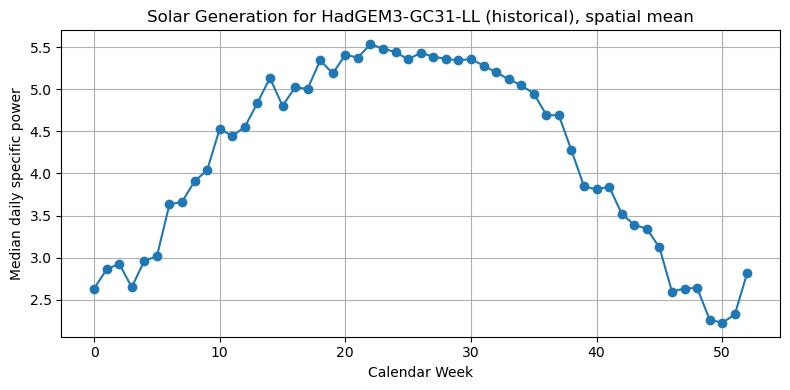

In [15]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL_1x1grid/historical/daily_mean_per_week.nc"
model="HadGEM3-GC31-LL"
period="historical"
ds=xr.open_dataset(file, engine="netcdf4")
p=ds['specific generation'].sel(y=41,x=2)
spatial_mean = ds['specific generation'].mean(dim=['y', 'x'])
plt.figure(figsize=(8, 4))
plt.plot(p, marker='o', linestyle='-')
plt.xlabel("Calendar Week")
plt.ylabel("Median daily specific power")
plt.title(f"Solar Generation for {model} ({period}), spatial mean")
plt.grid(True)
plt.tight_layout()
plt.show()



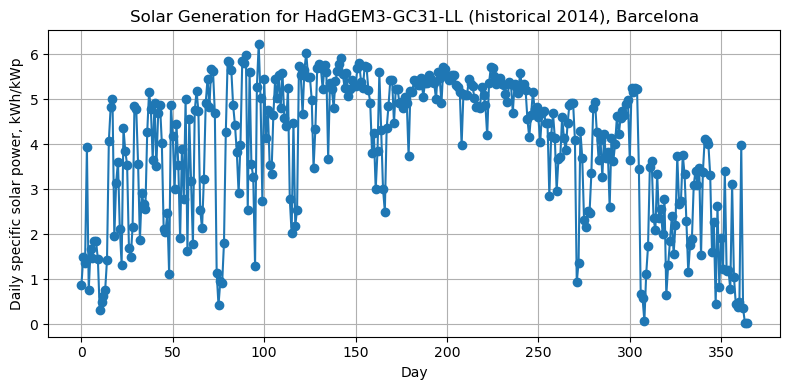

In [28]:
file="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/HadGEM3-GC31-LL_1x1grid/historical/daily_solar_power_2014.nc"
model="HadGEM3-GC31-LL"
period="historical 2014"
ds=xr.open_dataset(file, engine="netcdf4")
p=ds['specific generation'].sel(y=41,x=2)
spatial_mean = ds['specific generation'].mean(dim=['y', 'x'])
plt.figure(figsize=(8, 4))
plt.plot(p, marker='o', linestyle='-')
plt.xlabel("Day")
plt.ylabel("Daily specific solar power, kWh/kWp")
plt.title(f"Solar Generation for {model} ({period}), Barcelona")
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import xarray as xr

model = "HadGEM3-GC31-LL_1x1grid"
period = "ssp585"
base_path = "/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power"
#models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
original_day_path= f"{base_path}/{model}/{period}/solar_power_2099.nc"
daily_path = f"{base_path}/{model}/{period}/daily_solar_power_2099.nc"
weekly_path = f"{base_path}/{model}/{period}/daily_mean_per_week.nc"

# Load data
original_day=xr.open_dataarray(original_day_path)  # Assuming it's stored as a single DataArray
daily_ex = xr.open_dataarray(daily_path)  # Assuming it's stored as a single DataArray
weekly_clim_ex = xr.open_dataarray(weekly_path)


In [20]:
weekly_clim_ex

<xarray.DataArray 'specific generation' (weekofyear: 53, y: 40, x: 48)> Size: 814kB
[101760 values with dtype=float64]
Coordinates:
  * x           (x) float64 384B -12.0 -11.0 -10.0 -9.0 ... 32.0 33.0 34.0 35.0
    lon         (x) float64 384B ...
  * y           (y) float64 320B 33.0 34.0 35.0 36.0 ... 69.0 70.0 71.0 72.0
    lat         (y) float64 320B ...
  * weekofyear  (weekofyear) int64 424B 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53

In [19]:
daily_ex

<xarray.DataArray 'specific generation' (time: 365, y: 40, x: 48)> Size: 6MB
[700800 values with dtype=float64]
Coordinates:
  * x           (x) float64 384B -12.0 -11.0 -10.0 -9.0 ... 32.0 33.0 34.0 35.0
    lon         (x) float64 384B ...
  * y           (y) float64 320B 33.0 34.0 35.0 36.0 ... 69.0 70.0 71.0 72.0
    lat         (y) float64 320B ...
  * time        (time) datetime64[ns] 3kB 2099-01-01 2099-01-02 ... 2099-12-31
    weekofyear  (time) int64 3kB ...

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def inspect_day(daily_fullres, daily_ex, weekly_clim_ex, date_str):
    date = np.datetime64(date_str)
    
    # Extract full-resolution values for that day (e.g. 3-hourly)
    original_day = daily_fullres.sel(time=slice(date, date + np.timedelta64(1, 'D')), x=2, y=41)
    
    # Extract pre-aggregated daily value
    aggregated_day = daily_ex.sel(time=date, x=2, y=41)
    
    # Compute weekofyear dynamically (no need to access 'weekofyear' as a stored coordinate)
    weekofyear = aggregated_day['time'].dt.isocalendar().week.values.item()
    
    # Get the weekly climatological mean for that week
    mean_day_per_week = weekly_clim_ex.sel(weekofyear=weekofyear, x=2, y=41)
    
    # Select all daily values within the same week
    daily_ex_with_week = daily_ex.assign_coords(weekofyear=daily_ex['time'].dt.isocalendar().week)
    aggregated_days_in_week = daily_ex_with_week.sel(x=2, y=41).where(daily_ex_with_week.weekofyear == weekofyear, drop=True)

    
    # Print outputs
    print(f"\n=== {date_str} ===")
    print("Original sub-daily values:")
    print(original_day.values)
    print(f"Aggregated daily value: {aggregated_day.values}")
    print(f"Other days in the same week ({weekofyear=}): {aggregated_days_in_week['time'].values}")
    print(f"Daily values that week: {aggregated_days_in_week.values}")
    print(f"Weekly climatology (median): {mean_day_per_week.values}")
    
    # Optional plot
    plt.figure(figsize=(10, 4))
    original_day.plot(marker='o', label='Sub-daily values')
    plt.axhline(aggregated_day.values, color='black', linestyle='--', label='Daily aggregate')
    aggregated_days_in_week.plot(marker='o', label='Daily values that week')
    plt.axhline(mean_day_per_week.values, color='red', linestyle='--', label='Weekly climatology')
    plt.title(f"Sub-daily vs daily vs weekly (x=2, y=41) on {date_str}")
    plt.legend()
    plt.show()
    return aggregated_days_in_week.median(dim='time').values, mean_day_per_week



=== 2099-12-31 ===
Original sub-daily values:
[0.         0.         0.1048879  1.33613573 1.25368644 0.
 0.         0.        ]
Aggregated daily value: 2.6947100669779145
Other days in the same week (weekofyear=53): ['2099-12-28T00:00:00.000000000' '2099-12-29T00:00:00.000000000'
 '2099-12-30T00:00:00.000000000' '2099-12-31T00:00:00.000000000']
Daily values that week: [3.25264462 3.46954709 2.6976927  2.69471007]
Weekly climatology (median): 2.650863718434933


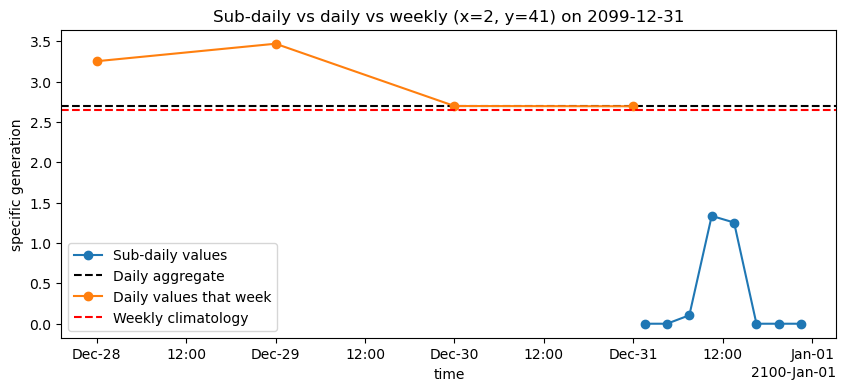

2099-01-01T00:00:00.000000000
2099-12-31T00:00:00.000000000


In [43]:
inspect_day(original_day, daily_ex, weekly_clim_ex, "2099-12-31")
print(daily_ex.time.min().values)
print(daily_ex.time.max().values)

In [45]:
# Step 1: Assign weekofyear to your daily dataset
daily_ex_with_week = daily_ex.assign_coords(weekofyear=daily_ex['time'].dt.isocalendar().week)

# Step 2: Choose a grid point and week to check
x_idx, y_idx = 2, 41
week_to_check = 53

# Step 3: Select all values in that week
week_data = daily_ex_with_week.sel(x=x_idx, y=y_idx).where(daily_ex_with_week.weekofyear == week_to_check, drop=True)

# Step 4: Compute the median manually
manual_median = week_data.median(dim='time').values

# Step 5: Compare to the stored climatology
stored_median = weekly_clim_ex.sel(weekofyear=week_to_check, x=x_idx, y=y_idx).values


print(f"Manual median for week {week_to_check}: {manual_median}")
print(f"Stored climatology for week {week_to_check}: {stored_median}")


Manual median for week 53: 2.9751686619357507
Stored climatology for week 53: 2.650863718434933


In [46]:
import xarray as xr
import numpy as np
import os

# Example: Load all yearly files from your target period
model = "HadGEM3-GC31-LL_1x1grid"
scenario = "ssp585"
base_path = f"/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/{model}/{scenario}"
years = range(2065, 2100)  # or whatever range is appropriate

# Load and concatenate daily solar power files
filepaths = [f"{base_path}/daily_solar_power_{year}.nc" for year in years if os.path.isfile(f"{base_path}/daily_solar_power_{year}.nc")]
datasets = [xr.open_dataarray(fp) for fp in filepaths]
daily_all_years = xr.concat(datasets, dim="time")

# Assign ISO week number
daily_all_years = daily_all_years.assign_coords(weekofyear=daily_all_years["time"].dt.isocalendar().week)

# Choose a week and grid point to check
week_to_check = 53
x_idx, y_idx = 2, 41

# Filter data to the target week
week_data = daily_all_years.sel(x=x_idx, y=y_idx).where(daily_all_years.weekofyear == week_to_check, drop=True)

# Compute the true climatological weekly median from all years
manual_median = week_data.median(dim="time").values

# Load precomputed weekly climatology
weekly_clim_path = f"{base_path}/daily_mean_per_week.nc"
weekly_clim = xr.open_dataarray(weekly_clim_path)

# Get stored value for same week/grid point
stored_median = weekly_clim.sel(weekofyear=week_to_check, x=x_idx, y=y_idx).values

# Compare
print(f"Computed median from all years: {manual_median}")
print(f"Stored climatology:             {stored_median}")


Computed median from all years: 2.650863718434933
Stored climatology:             2.650863718434933


In [118]:
import os
import xarray as xr
import pandas as pd
import numpy as np
from itertools import groupby

drought_all = []
models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2", "HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
#models=["ACCESS-CM2"]

def drought_stats_1d(series):
    """Calculate drought statistics for a 1D boolean array."""
    lengths = [sum(1 for _ in g) for k, g in groupby(series) if k]
    if not lengths:
        return (0, 0.0, 0, 0, 0, 0)
    lengths = np.array(lengths)
    return (
        len(lengths),
        float(np.median(lengths)),
        int(np.max(lengths)),
        int(np.sum(lengths >= 5)),
        int(np.sum(lengths >= 7)),
        int(np.sum(lengths >= 10))
    )

for model in models:
    for period, info in periods.items():
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        output_dir = base_dir

        # Load weekly climatology
        weekly_file = os.path.join(output_dir, "daily_mean_per_week.nc")
        if not os.path.isfile(weekly_file):
            print(f"Missing weekly climatology for {model} - {period}, skipping.")
            continue
        weekly_clim = xr.open_dataset(weekly_file)['specific generation']

        for yr in info['years']:
            print(f"    ➤ Year: {yr}")
            daily_file = os.path.join(output_dir, f"daily_solar_power_{yr}.nc")
            if not os.path.isfile(daily_file):
                print(f"Missing daily data for {model} - {period} - Year: {yr}, skipping.")
                continue

            # Load daily data: shape (time, y, x)
            daily_year = xr.open_dataset(daily_file)['specific generation']
            daily_year = daily_year.assign_coords(weekofyear=daily_year['time'].dt.isocalendar().week)

            # Compute threshold
            threshold = weekly_clim * 0.3
            daily_threshold = threshold.sel(weekofyear=daily_year['weekofyear'])

            daily_threshold = threshold.sel(weekofyear=daily_year['weekofyear'])

            # Identify drought days
            is_drought = daily_year < daily_threshold
            # Print the type and shape of is_drought
            print(f"is_drought type: {type(is_drought)}")
            print(f"is_drought shape: {is_drought.shape}")
            # Count total drought days per year, per grid cell
            drought_days = is_drought.sum(dim='time')
            print(f"drough_days type: {type(drought_days)}")
            print(f"drough_days shape: {drought_days.shape}")

            # Calculate total drought duration (sum of all drought days)
            total_drought_duration = drought_days.sum(dim=['y', 'x'])

            # Calculate spatial extent (percentage of grid cells affected by drought)
            # Calculate spatial extent (percentage of grid cells affected by drought)
        
            # Seasonal analysis
            seasons = {
                "DJF": [12, 1, 2],
                "MAM": [3, 4, 5],
                "JJA": [6, 7, 8],
                "SON": [9, 10, 11]
            }
            seasonal_drought = {}
            for season, months in seasons.items():
                seasonal_data = daily_year.sel(time=daily_year['time.month'].isin(months))
                seasonal_threshold = threshold.sel(weekofyear=seasonal_data['weekofyear'])
                seasonal_is_drought = seasonal_data < seasonal_threshold
                seasonal_drought[season] = seasonal_is_drought.sum(dim='time')

            # Identify drought events
            event_stats = xr.apply_ufunc(
                drought_stats_1d,
                is_drought,
                input_core_dims=[['time']],
                output_core_dims=[[], [], [], [], [], []],
                vectorize=True,
                dask='parallelized',
                output_dtypes=[int, float, int, int, int, int],
            )
            print(f"drough_days type: {type(event_stats[1])}")
            print(f"drough_days shape: {event_stats[1].shape}")
            # Save to file
            # Save to file
            drought_output_file = os.path.join(output_dir, f"drought_stats_{yr}.nc")
            if not os.path.isfile(drought_output_file):
                xr.Dataset({
                    'drought_days': drought_days,
                    'total_drought_duration': total_drought_duration,
                    # 'spatial_extent': spatial_extent,
                    'drought_events': event_stats[0],
                    'median_event_duration': event_stats[1],
                    'max_event_duration': event_stats[2],
                    'events_ge_5d': event_stats[3],
                    'events_ge_7d': event_stats[4],
                    'events_ge_10d': event_stats[5],
                    'seasonal_drought_DJF': seasonal_drought['DJF'],
                    'seasonal_drought_MAM': seasonal_drought['MAM'],
                    'seasonal_drought_JJA': seasonal_drought['JJA'],
                    'seasonal_drought_SON': seasonal_drought['SON'],
                }).to_netcdf(drought_output_file)
                print(f"    💾 Saved spatial drought stats to {drought_output_file}")
            else:
                print(f"    ⚠️ File already exists, skipping: {drought_output_file}")

    ➤ Year: 1980
is_drought type: <class 'xarray.core.dataarray.DataArray'>
is_drought shape: (366, 40, 48)
drough_days type: <class 'xarray.core.dataarray.DataArray'>
drough_days shape: (40, 48)
drough_days type: <class 'xarray.core.dataarray.DataArray'>
drough_days shape: (40, 48)
    ⚠️ File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/drought_stats_1980.nc
    ➤ Year: 1981
is_drought type: <class 'xarray.core.dataarray.DataArray'>
is_drought shape: (365, 40, 48)
drough_days type: <class 'xarray.core.dataarray.DataArray'>
drough_days shape: (40, 48)
drough_days type: <class 'xarray.core.dataarray.DataArray'>
drough_days shape: (40, 48)
    ⚠️ File already exists, skipping: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/drought_stats_1981.nc
    ➤ Year: 1982
is_drought type: <class 'xarray.core.dataarray.DataArray'>
is_drought shape: (365, 40, 

In [119]:
print(is_drought.sum().item(), "drought days in total")

78956 drought days in total


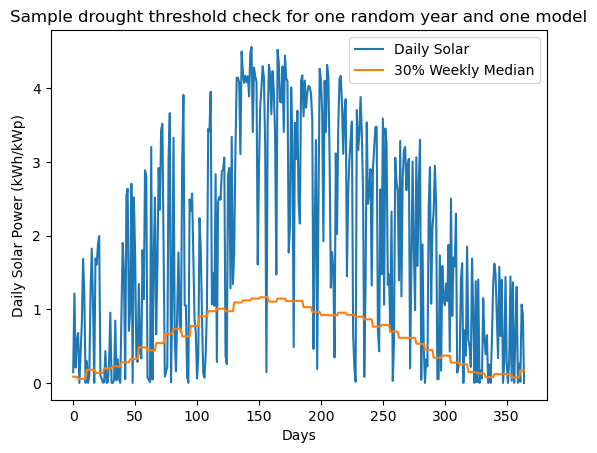

In [120]:
import matplotlib.pyplot as plt

i, j = 20, 5  # pick a sample y, x index

daily_series = daily_year[:, i, j]
threshold_series = daily_threshold[:, i, j]

plt.plot(daily_series, label="Daily Solar")
plt.plot(threshold_series, label="30% Weekly Median")
plt.legend()
plt.title("Sample drought threshold check for one random year and one model")
plt.xlabel("Days")
plt.ylabel("Daily Solar Power (kWh/kWp)")
plt.show()


In [121]:
path="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/drought_stats_2097.nc"
ds=xr.open_dataset(path, engine="netcdf4")
ds

<xarray.Dataset> Size: 170kB
Dimensions:                 (x: 48, y: 40)
Coordinates:
  * x                       (x) float64 384B -12.0 -11.0 -10.0 ... 34.0 35.0
    lon                     (x) float64 384B ...
  * y                       (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
    lat                     (y) float64 320B ...
Data variables:
    drought_days            (y, x) int64 15kB ...
    total_drought_duration  int64 8B ...
    drought_events          (y, x) int64 15kB ...
    median_event_duration   (y, x) float64 15kB ...
    max_event_duration      (y, x) int64 15kB ...
    events_ge_5d            (y, x) int64 15kB ...
    events_ge_7d            (y, x) int64 15kB ...
    events_ge_10d           (y, x) int64 15kB ...
    seasonal_drought_DJF    (y, x) int64 15kB ...
    seasonal_drought_MAM    (y, x) int64 15kB ...
    seasonal_drought_JJA    (y, x) int64 15kB ...
    seasonal_drought_SON    (y, x) int64 15kB ...

In [113]:
# Load power-based mask
power_data = xr.open_dataset("/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/solar_power_2014.nc")['specific generation']
power_mask = (power_data.sum(dim='time') < 1e-3)


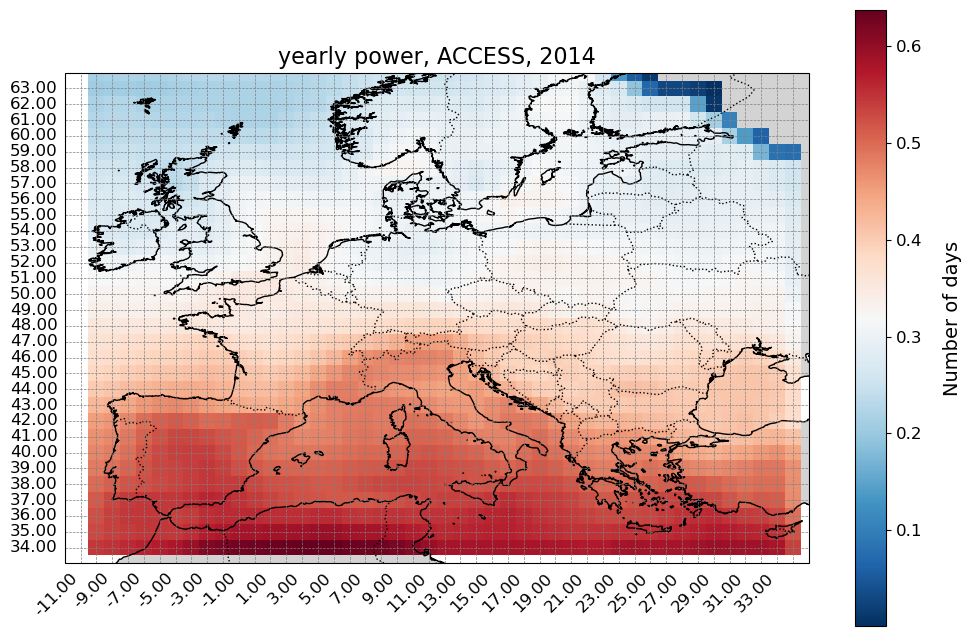

In [114]:
from plots import map_plots
power_data = power_data.mean(dim='time')
power_data=power_data.where(~power_mask)
map_plots(power_data, cmap='RdBu_r', setnan=False, vmin=None, vmax=None,
          title=f'yearly power, ACCESS, 2014', label='Number of days')

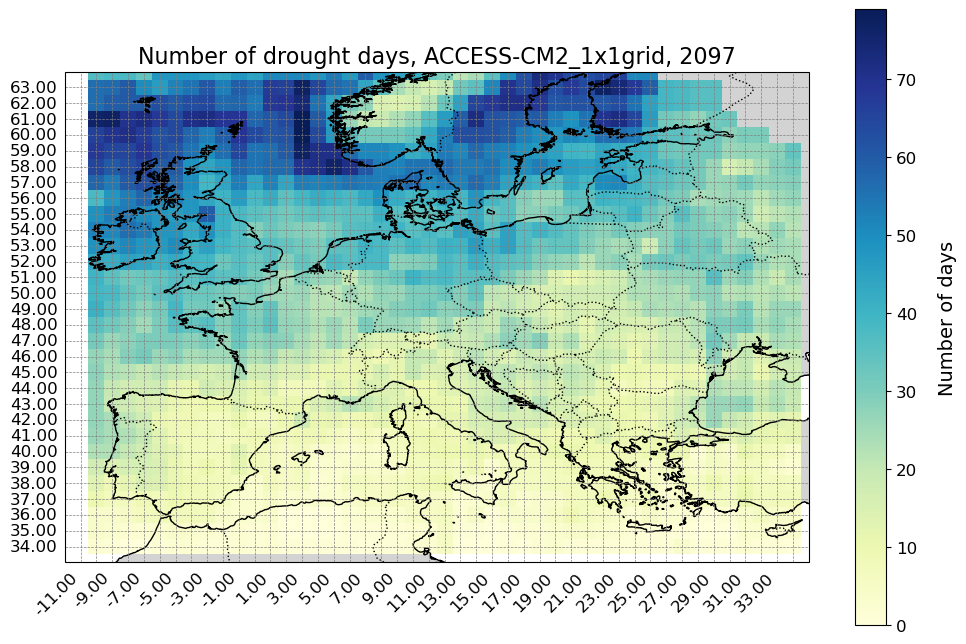

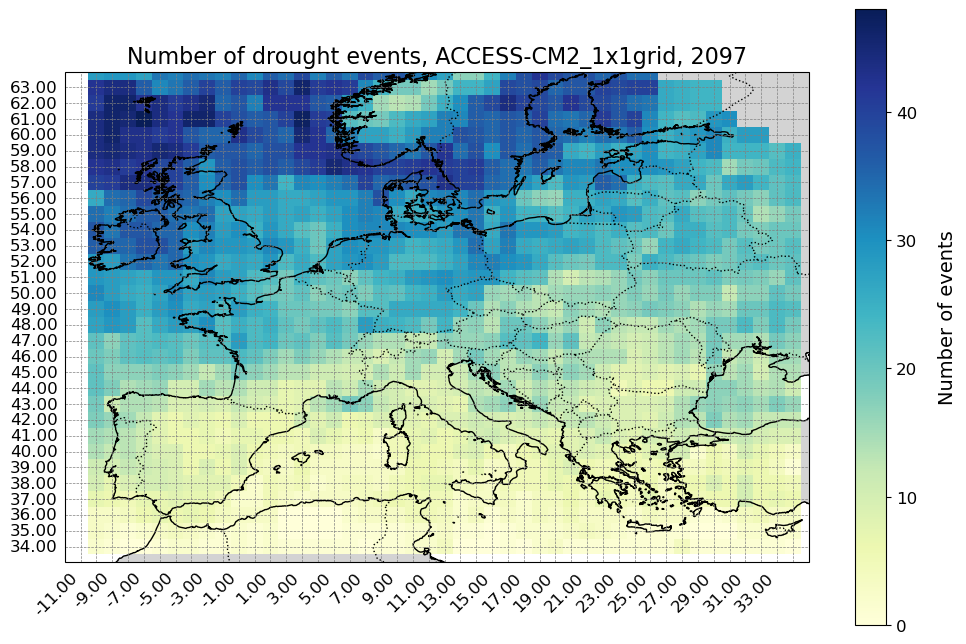

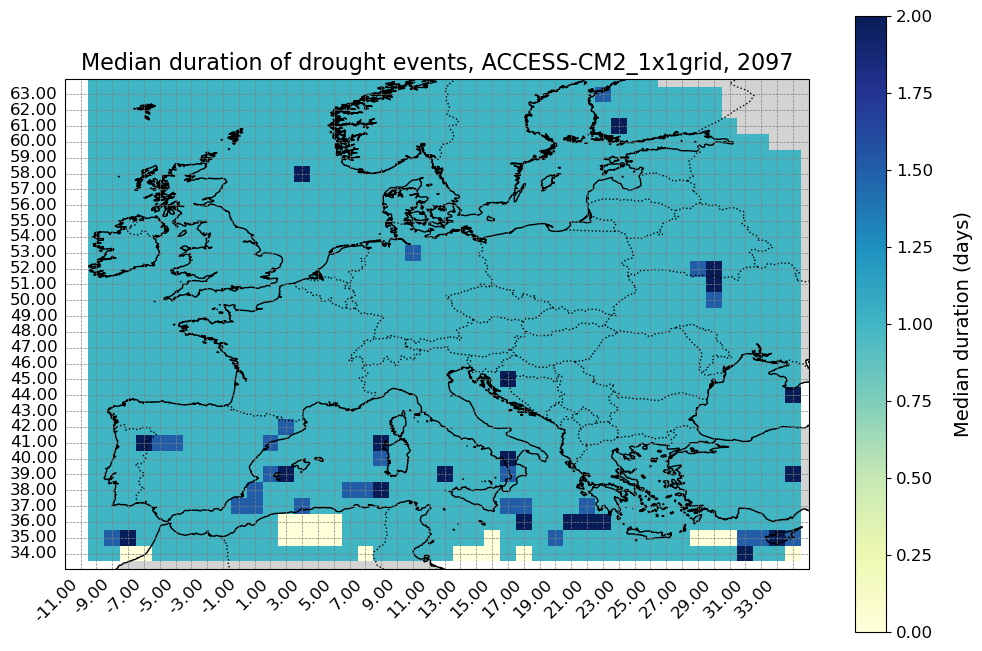

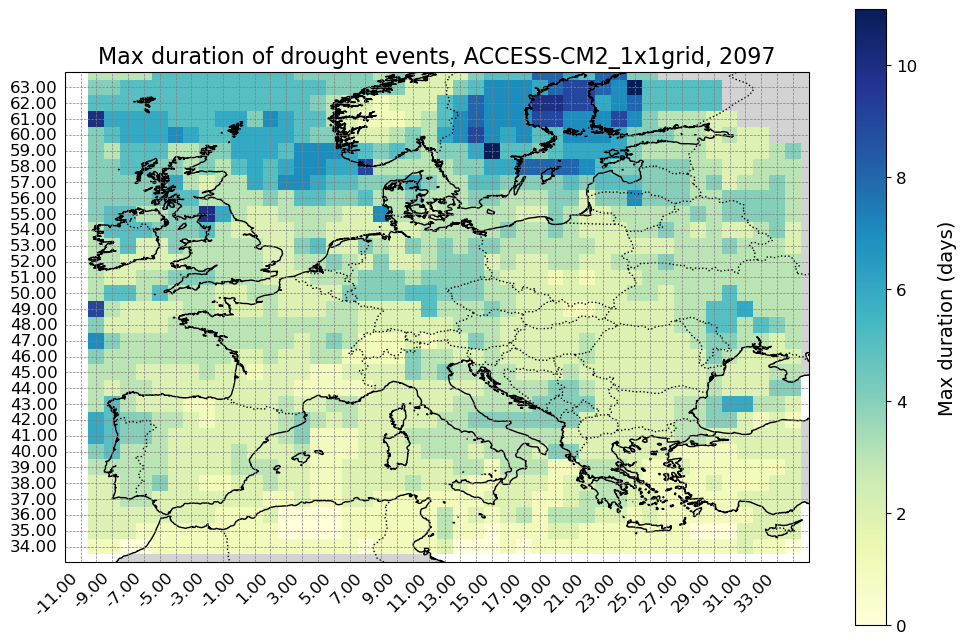

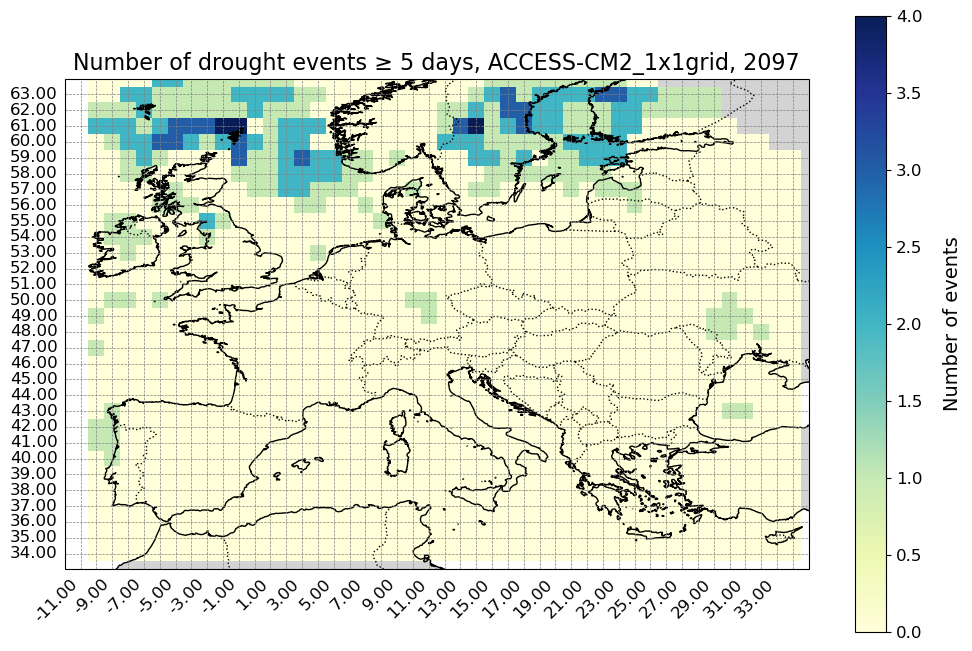

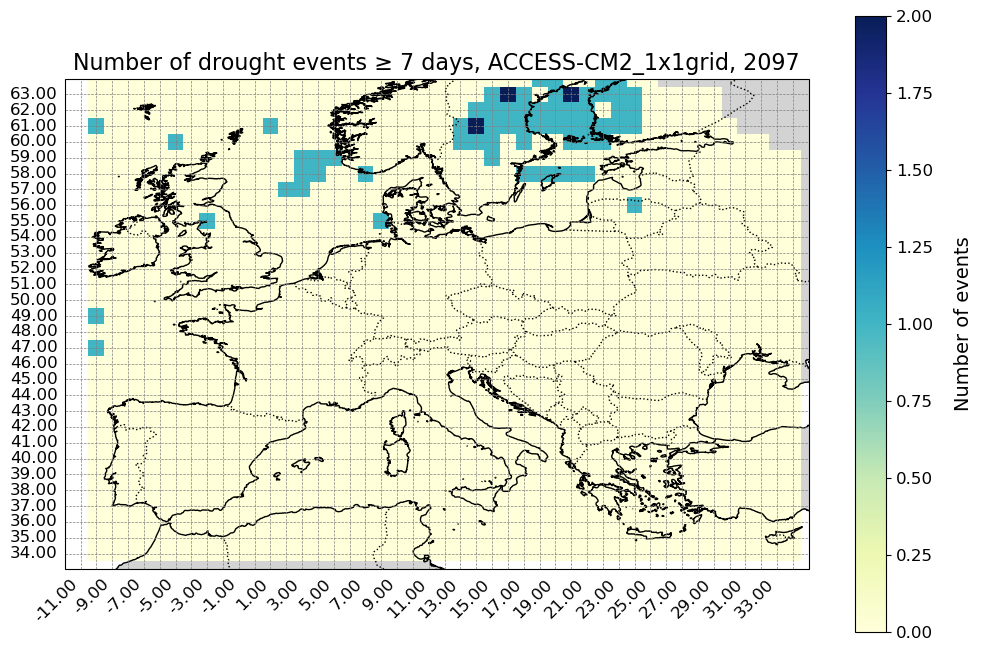

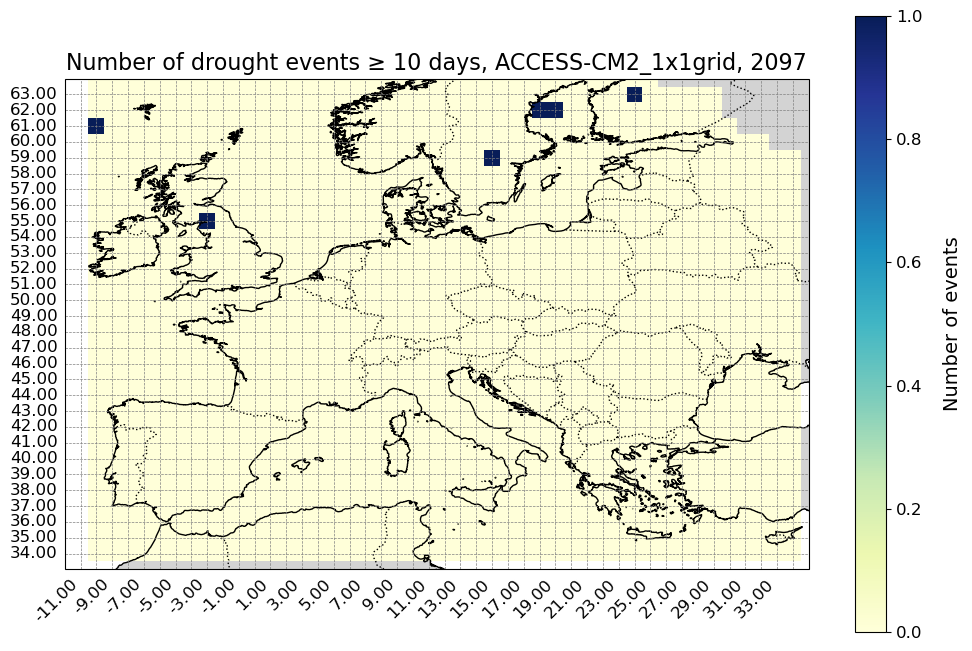

In [122]:
from plots import map_plots
model="ACCESS-CM2_1x1grid"
year="2097"
# Load your dataset
num_drought_days = ds['drought_days']
num_drought_events = ds['drought_events']
median_event_duration = ds['median_event_duration']
max_event_duration = ds['max_event_duration']
events_ge_5d = ds['events_ge_5d']
events_ge_7d = ds['events_ge_7d']
events_ge_10d = ds['events_ge_10d']

# Define and broadcast corner mask (for SARAH-3 wedge artifact)
corner_mask = (ds['drought_days'].x + ds['drought_days'].y) > 94
corner_mask = corner_mask.broadcast_like(ds['drought_days'])  # Ensure shape match
coner_mask=power_mask

# Apply the mask (set NaN where mask is True)
num_drought_days = num_drought_days.where(~power_mask)
num_drought_events = num_drought_events.where(~power_mask)
median_event_duration = median_event_duration.where(~power_mask)
max_event_duration = max_event_duration.where(~power_mask)
events_ge_5d = events_ge_5d.where(~power_mask)
events_ge_7d = events_ge_7d.where(~power_mask)
events_ge_10d = events_ge_10d.where(~power_mask)
cmap='YlGnBu'

# Plot results with setnan=False
map_plots(num_drought_days, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought days, {model}, {year}', label='Number of days')

map_plots(num_drought_events, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events, {model}, {year}', label='Number of events')

map_plots(median_event_duration, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Median duration of drought events, {model}, {year}', label='Median duration (days)')

map_plots(max_event_duration, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Max duration of drought events, {model}, {year}', label='Max duration (days)')

map_plots(events_ge_5d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 5 days, {model}, {year}', label='Number of events')

map_plots(events_ge_7d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 7 days, {model}, {year}', label='Number of events')

map_plots(events_ge_10d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 10 days, {model}, {year}', label='Number of events')


In [ ]:
import glob
import re
#models = ["ACCESS-CM2", "CanESM5", "CMCC-CM2-SR5", "CMCC-ESM2","HadGEM3-GC31-LL", "HadGEM3-GC31-MM", "MRI-ESM2-0"]
models=["ACCESS-CM2"]
for model in models:
    print(f"\n🔍 Aggregating for model: {model}")
    for period, info in periods.items():
        print(f"  ▶ Period: {period}")
        
        base_dir = os.path.join(diri, f"{model}_1x1grid", info['subpath'])
        file_pattern = os.path.join(base_dir, "drought_stats_*.nc")
        drought_files = [ fp for fp in glob.glob(file_pattern) if re.search(r"drought_stats_\d{4}\.nc$", os.path.basename(fp))]

        if not drought_files:
            print(f"  ⚠️ No drought files found for {model} - {period}")
            continue

        # Load all annual drought stats
        datasets = [xr.open_dataset(fp).expand_dims(year=[int(os.path.basename(fp).split("_")[-1].split(".")[0])])
                    for fp in drought_files]

        combined = xr.concat(datasets, dim="year")

        # Median across years (per grid cell)
        median_stats = combined.median(dim="year")
        mean_stats= combined.mean(dim="year")

        # Optionally also compute spatial mean over grid for reporting
        #spatial_mean = median_stats.mean(dim=['x', 'y'])

        # Save per-model, per-period median map
        median_output_path = os.path.join(base_dir, f"drought_stats_median_{period}.nc")
        median_stats.to_netcdf(median_output_path)
        print(f"  💾 Saved median drought stats for {model} - {period}: {median_output_path}")

        # Print global (spatial) mean summary
        print(f"    ⬩ Spatial mean (model: {model}, period: {period}):")
        for var in spatial_mean.data_vars:
            print(f"      {var}: {spatial_mean[var].item():.2f}")



🔍 Aggregating for model: ACCESS-CM2
  ▶ Period: BOC
  💾 Saved median drought stats for ACCESS-CM2 - BOC: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/drought_stats_median_BOC.nc
    ⬩ Spatial mean (model: ACCESS-CM2, period: BOC):
      drought_days: 41.97
      drought_events: 27.91
      median_event_duration: 0.73
      max_event_duration: 3.14
      events_ge_5d: 0.44
      events_ge_7d: 0.03
      events_ge_10d: 0.00
  ▶ Period: EOC
  💾 Saved median drought stats for ACCESS-CM2 - EOC: /work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/drought_stats_median_EOC.nc
    ⬩ Spatial mean (model: ACCESS-CM2, period: EOC):
      drought_days: 41.97
      drought_events: 27.91
      median_event_duration: 0.73
      max_event_duration: 3.14
      events_ge_5d: 0.44
      events_ge_7d: 0.03
      events_ge_10d: 0.00


In [127]:
file_BOC="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/historical/drought_stats_median_BOC.nc"
file_EOC="/work/users/s233224/Climate-Change-Impacted-Solar-Energy-Generation/power/ACCESS-CM2_1x1grid/ssp585/drought_stats_median_EOC.nc"
ds_BOC=xr.open_dataset(file_BOC, engine="netcdf4")
ds_EOC=xr.open_dataset(file_EOC, engine="netcdf4")

In [128]:
ds_BOC

<xarray.Dataset> Size: 170kB
Dimensions:                 (y: 40, x: 48)
Coordinates:
  * x                       (x) float64 384B -12.0 -11.0 -10.0 ... 34.0 35.0
    lon                     (x) float64 384B ...
  * y                       (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
    lat                     (y) float64 320B ...
Data variables:
    drought_days            (y, x) float64 15kB ...
    total_drought_duration  float64 8B ...
    drought_events          (y, x) float64 15kB ...
    median_event_duration   (y, x) float64 15kB ...
    max_event_duration      (y, x) float64 15kB ...
    events_ge_5d            (y, x) float64 15kB ...
    events_ge_7d            (y, x) float64 15kB ...
    events_ge_10d           (y, x) float64 15kB ...
    seasonal_drought_DJF    (y, x) float64 15kB ...
    seasonal_drought_MAM    (y, x) float64 15kB ...
    seasonal_drought_JJA    (y, x) float64 15kB ...
    seasonal_drought_SON    (y, x) float64 15kB ...

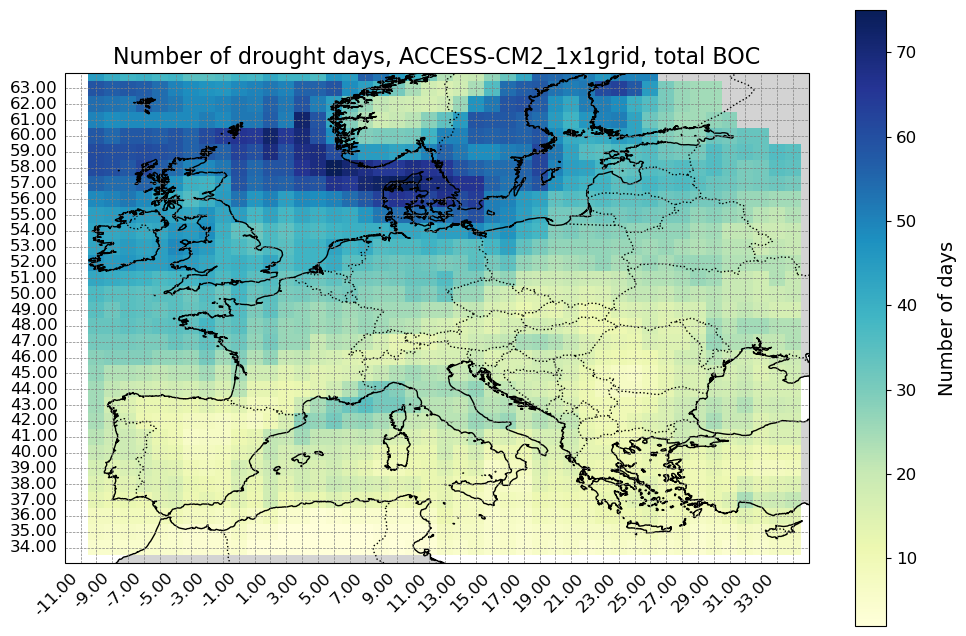

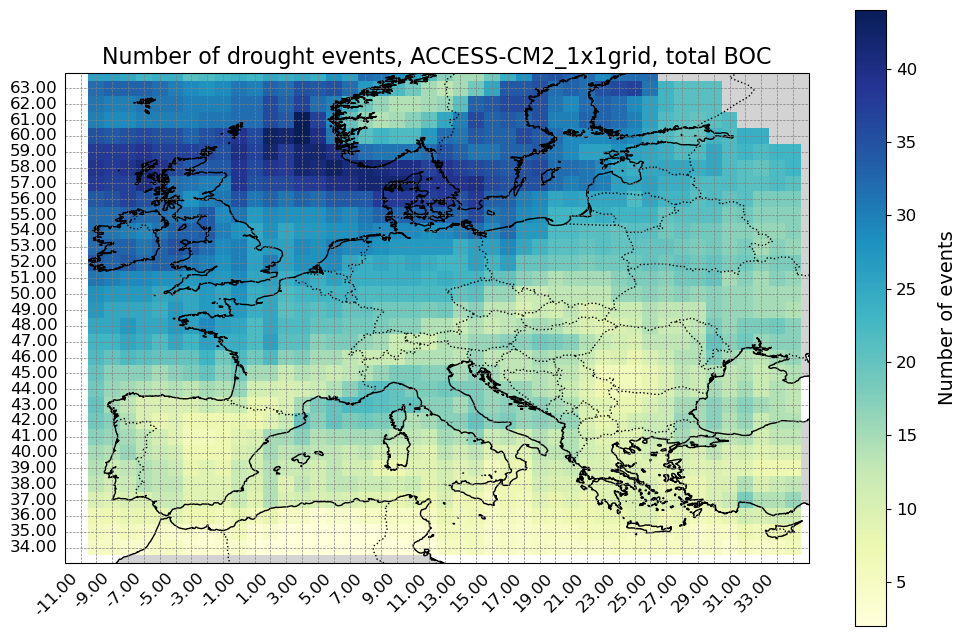

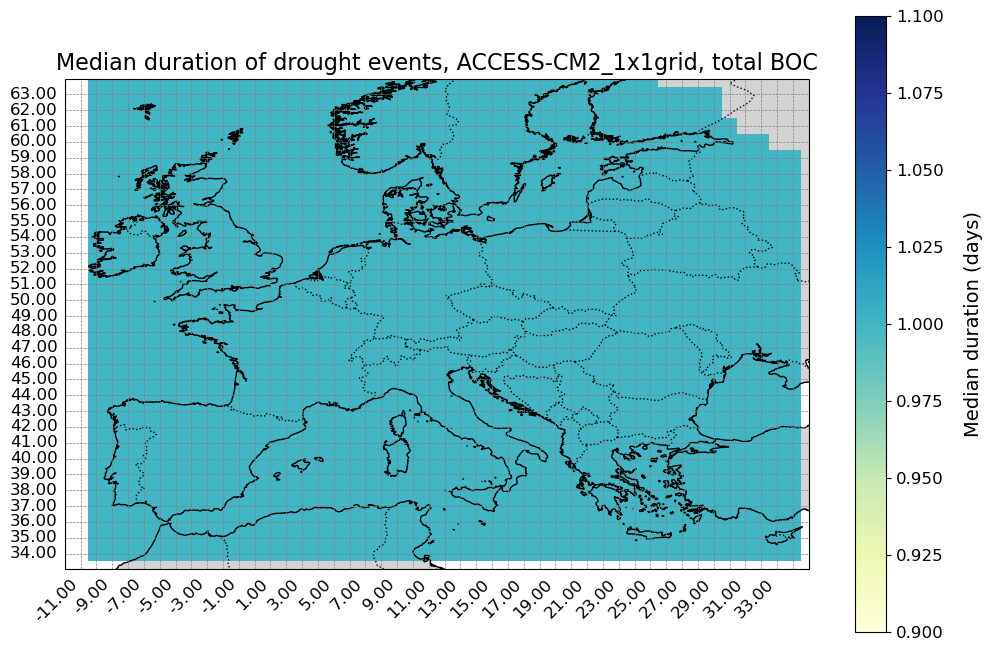

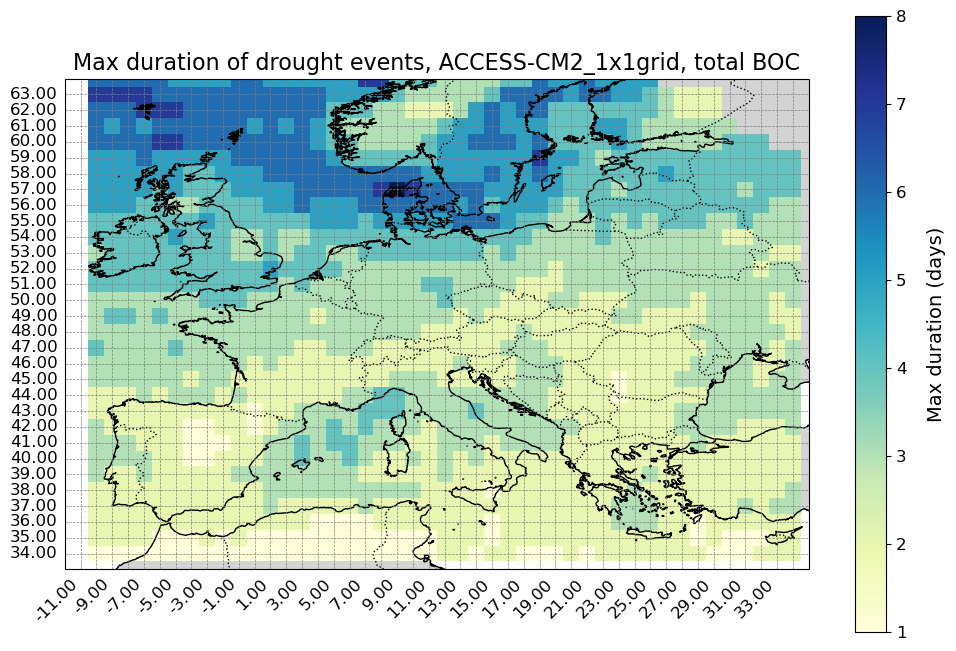

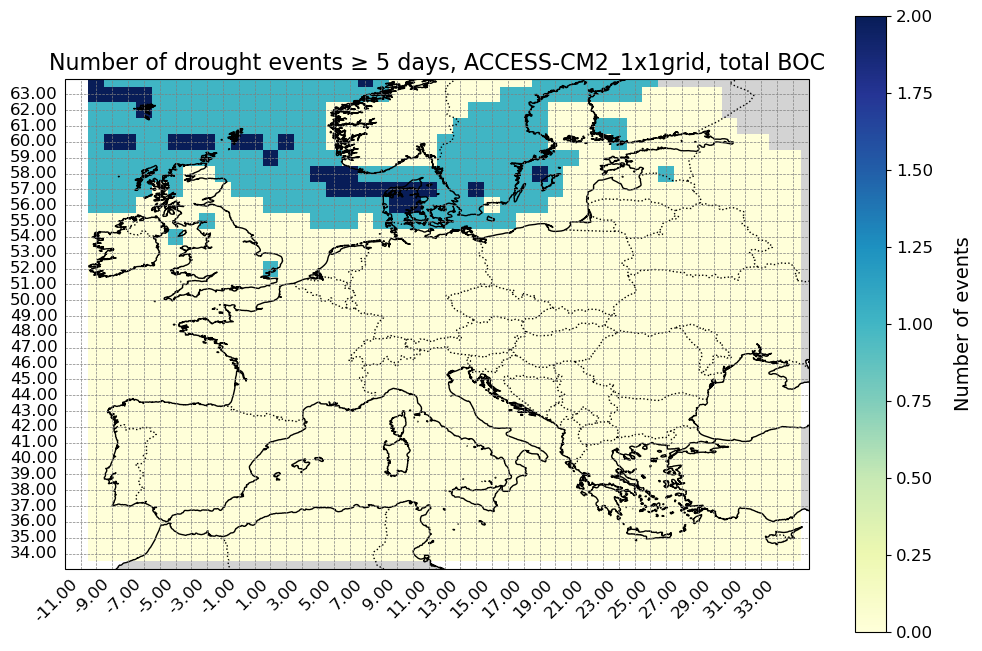

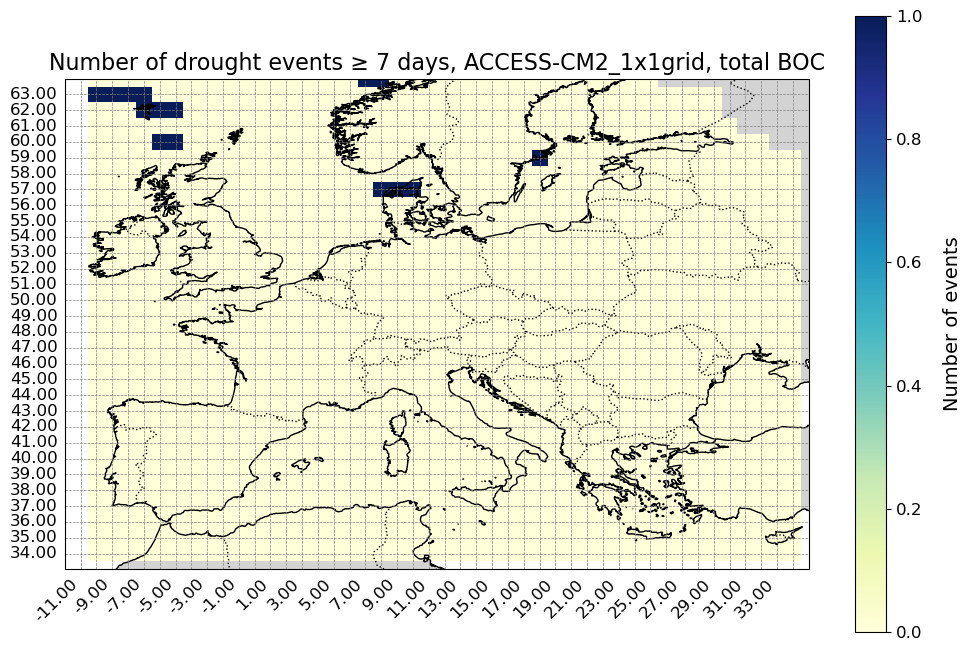

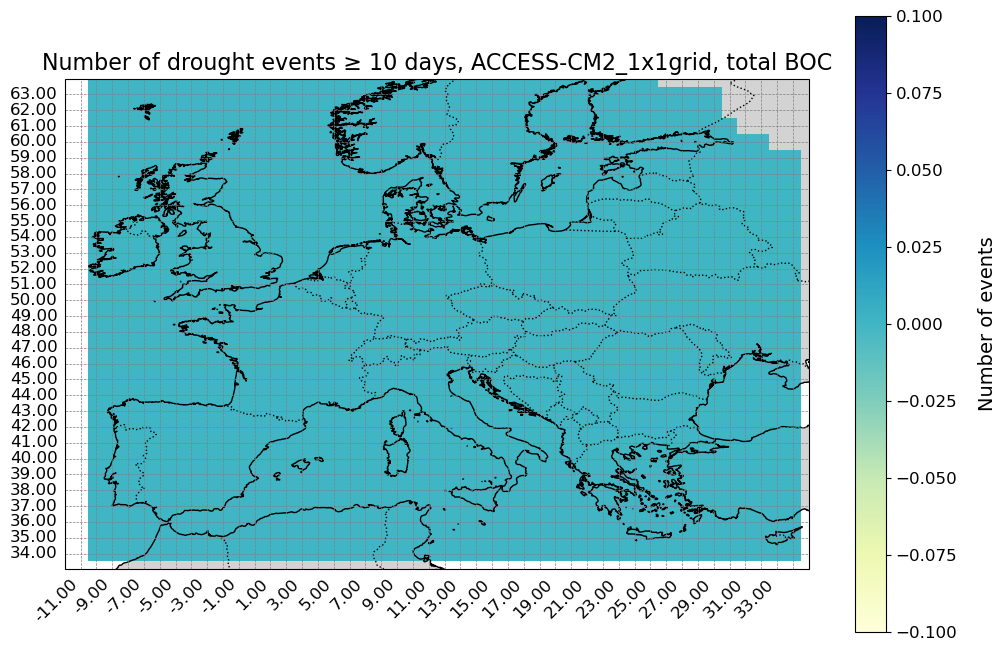

In [129]:
from plots import map_plots
model="ACCESS-CM2_1x1grid"
year="total BOC"
# Load your dataset
num_drought_days = ds_BOC['drought_days']
num_drought_events = ds_BOC['drought_events']
median_event_duration = ds_BOC['median_event_duration']
max_event_duration = ds_BOC['max_event_duration']
events_ge_5d = ds_BOC['events_ge_5d']
events_ge_7d = ds_BOC['events_ge_7d']
events_ge_10d = ds_BOC['events_ge_10d']

# Apply the mask (set NaN where mask is True)
num_drought_days = num_drought_days.where(~power_mask)
num_drought_events = num_drought_events.where(~power_mask)
median_event_duration = median_event_duration.where(~power_mask)
max_event_duration = max_event_duration.where(~power_mask)
events_ge_5d = events_ge_5d.where(~power_mask)
events_ge_7d = events_ge_7d.where(~power_mask)
events_ge_10d = events_ge_10d.where(~power_mask)
cmap='YlGnBu'

# Plot results with setnan=False
map_plots(num_drought_days, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought days, {model}, {year}', label='Number of days')

map_plots(num_drought_events, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events, {model}, {year}', label='Number of events')

map_plots(median_event_duration, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Median duration of drought events, {model}, {year}', label='Median duration (days)')

map_plots(max_event_duration, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Max duration of drought events, {model}, {year}', label='Max duration (days)')

map_plots(events_ge_5d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 5 days, {model}, {year}', label='Number of events')

map_plots(events_ge_7d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 7 days, {model}, {year}', label='Number of events')

map_plots(events_ge_10d, cmap=cmap, setnan=False, vmin=None, vmax=None,
          title=f'Number of drought events ≥ 10 days, {model}, {year}', label='Number of events')


In [87]:
ds_diff = ds_EOC - ds_BOC
threshold_Nan = 1e-10

In [88]:
print(ds_diff)
print(ds_diff['drought_days'].mean().item(), "avg change in drought days")
print(ds_diff['drought_events'].mean().item(), "avg change in event count")


<xarray.Dataset> Size: 109kB
Dimensions:                (x: 48, y: 40)
Coordinates:
  * x                      (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
    lon                    (x) float64 384B -12.0 -11.0 -10.0 ... 33.0 34.0 35.0
  * y                      (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
    lat                    (y) float64 320B 33.0 34.0 35.0 ... 70.0 71.0 72.0
Data variables:
    drought_days           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    drought_events         (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    median_event_duration  (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    max_event_duration     (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_5d           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_7d           (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    events_ge_10d          (y, x) float64 15kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
0.0203125 avg change in droug

In [89]:
ds_BOC['events_ge_7d'].max().item(), ds_EOC['events_ge_7d'].max().item()


(1.0, 1.0)

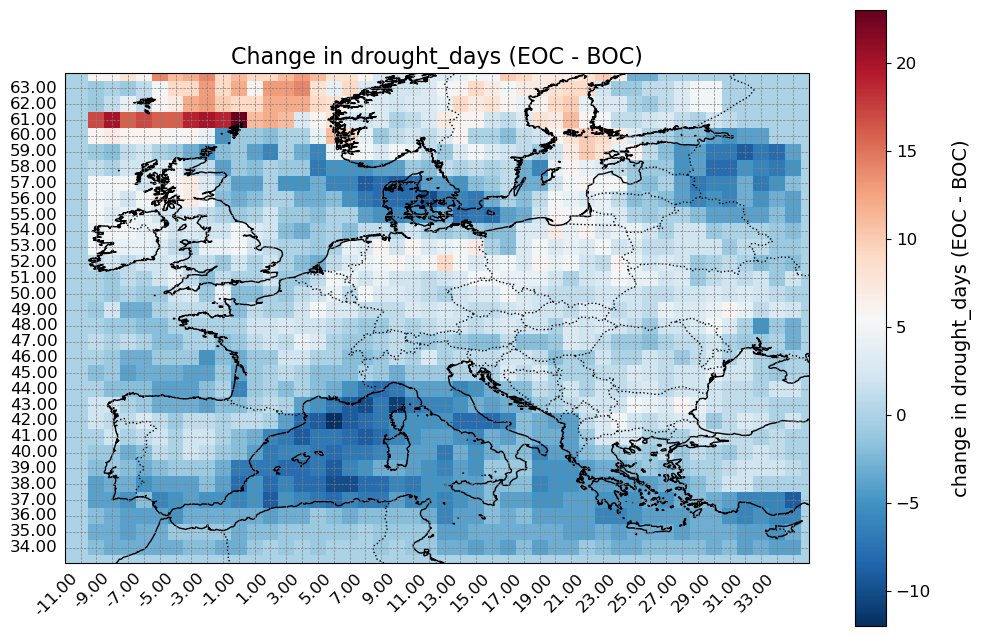

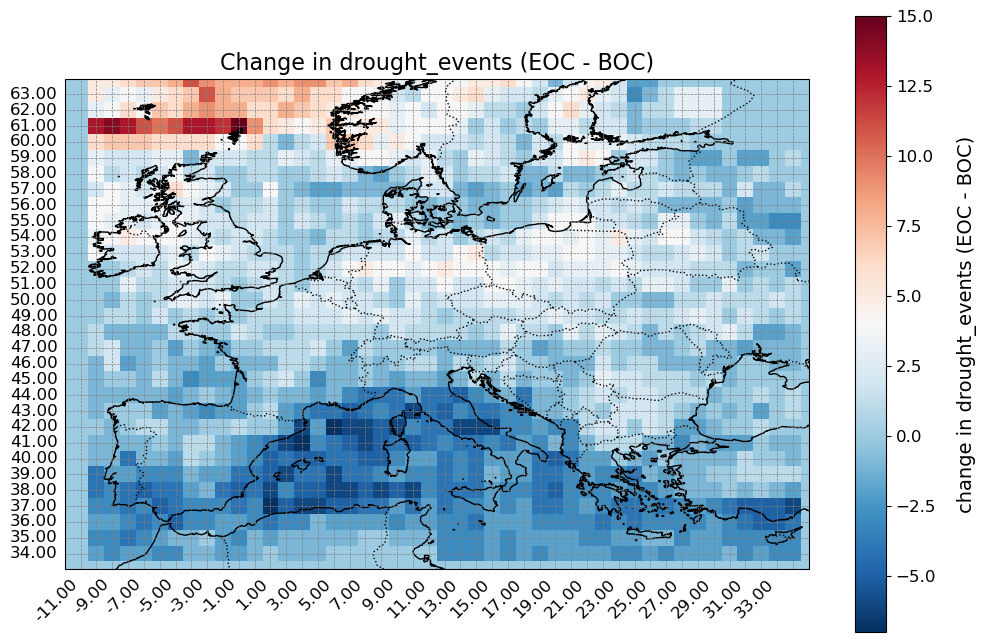

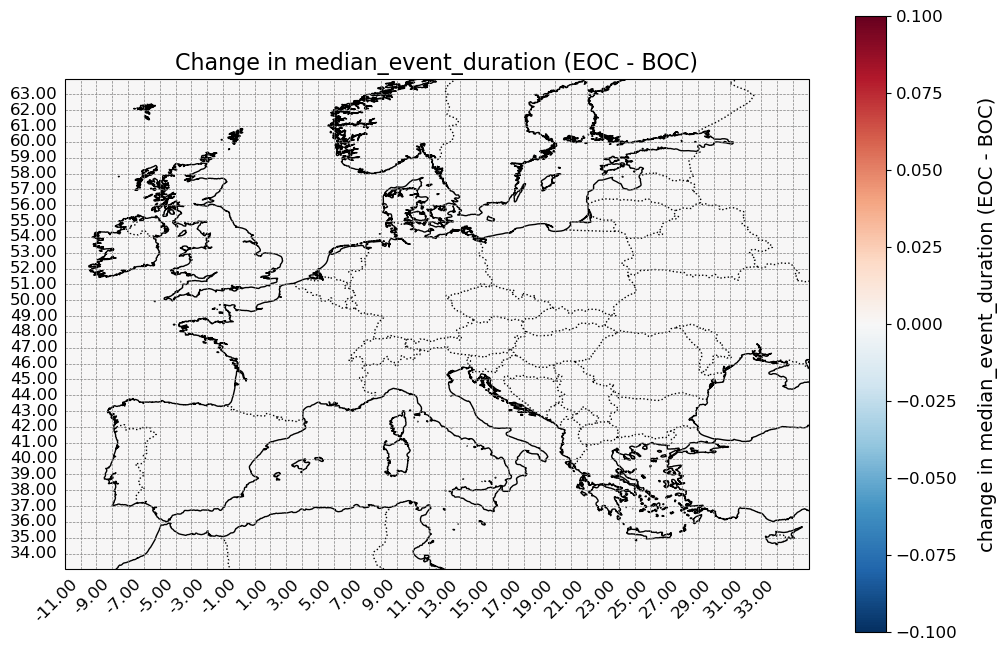

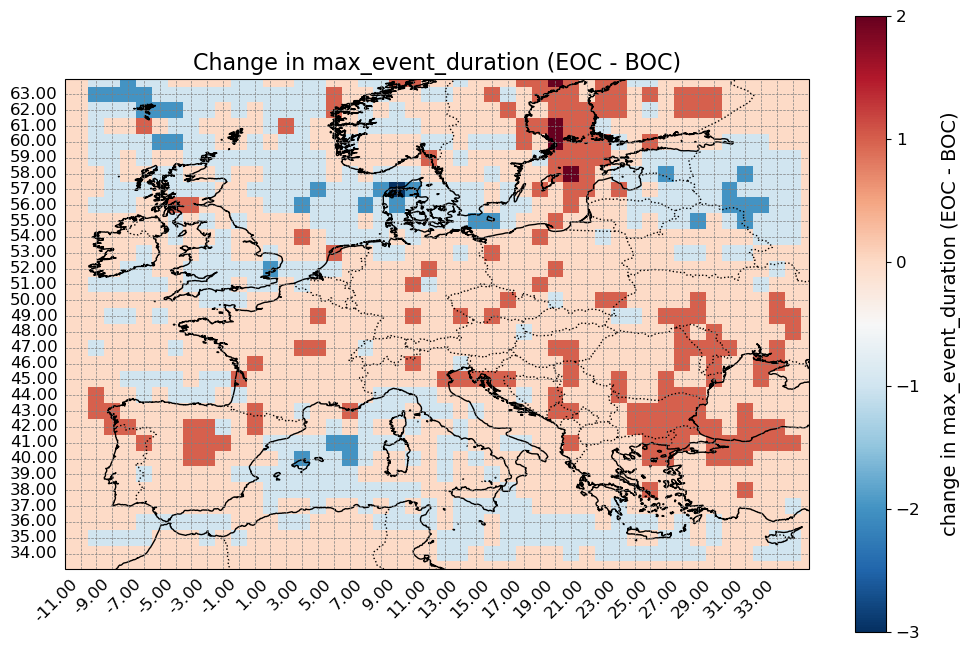

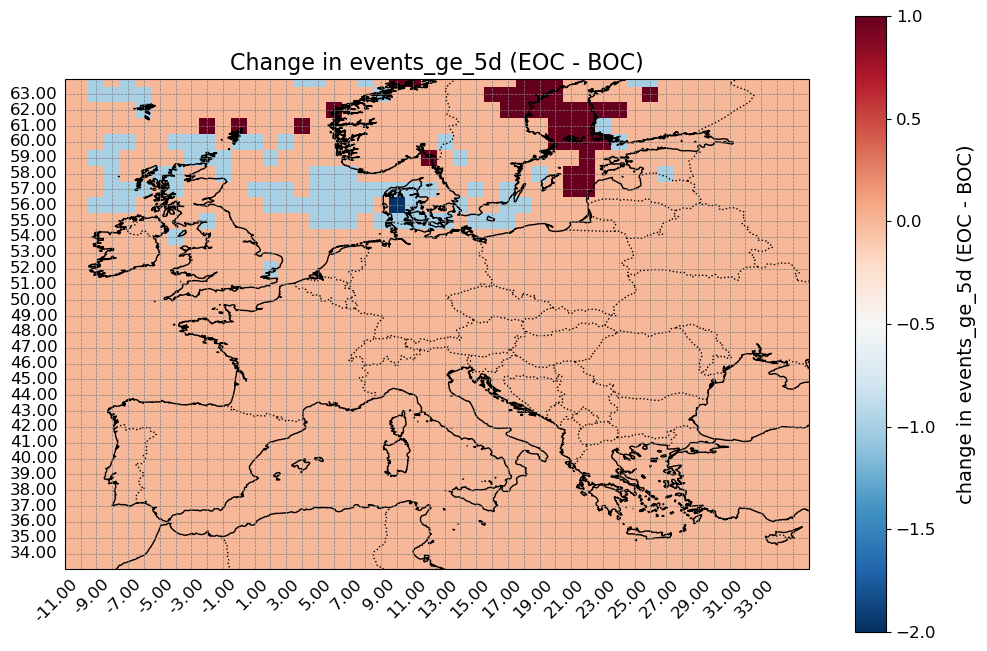

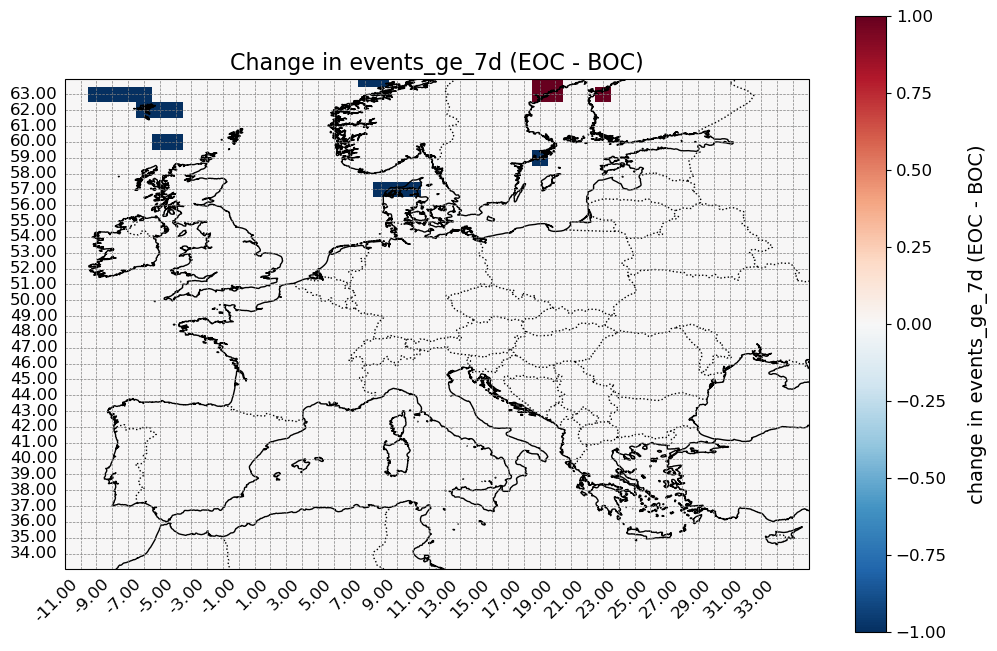

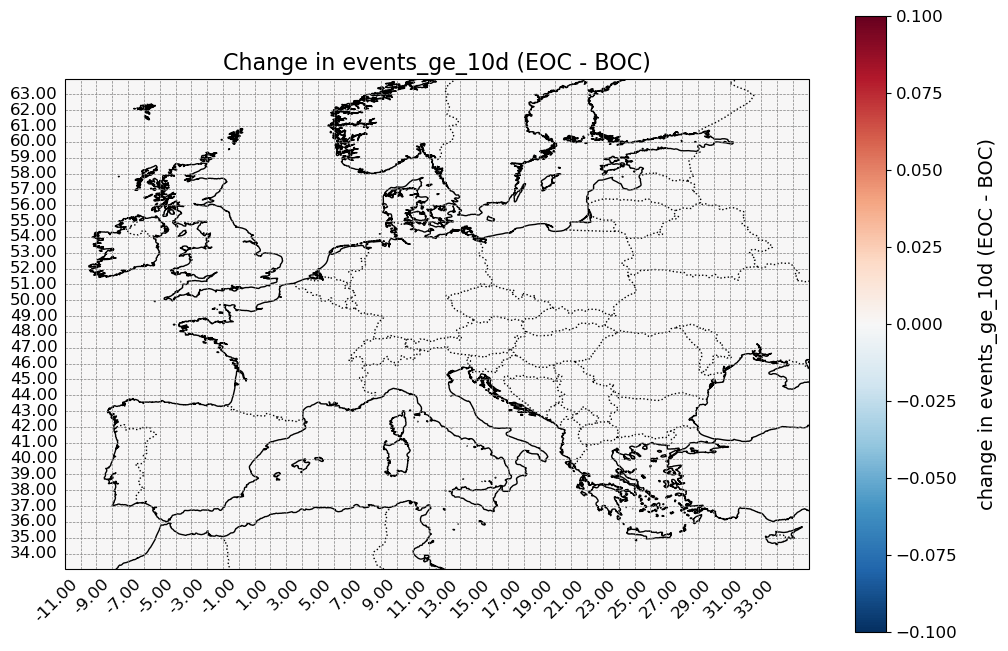

In [90]:
import matplotlib.pyplot as plt

for var in ds_diff.data_vars:
    map_plots(
        ds_diff[var], 
        cmap='RdBu_r', 
        setnan=True, 
        vmin=None, 
        vmax=None, 
        title=f"Change in {var} (EOC - BOC)", 
        label=f"change in {var} (EOC - BOC)"
    )


In [93]:
#trying to understand where are the Nans coming from
print(weekly_clim.isnull().sum(dim='weekofyear'))  # NaNs per pixel


<xarray.DataArray 'specific generation' (y: 40, x: 48)> Size: 15kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) float64 384B -12.0 -11.0 -10.0 -9.0 ... 32.0 33.0 34.0 35.0
    lon      (x) float64 384B ...
  * y        (y) float64 320B 33.0 34.0 35.0 36.0 37.0 ... 69.0 70.0 71.0 72.0
    lat      (y) float64 320B ...
